In [ ]:
# Mount google drive and move to the project's directory
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/my_icdar

In [ ]:
import os
import tensorflow as tf

from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

try:
    from patchify import (patchify, unpatchify)
except:
    % pip install patchify
    from patchify import (patchify, unpatchify)

In [ ]:
# Display a list with the available models and ask the user to choose which to use
models_path = 'models'
models_list = os.listdir(models_path)

# create a dictionary with numbers as keys and the model names as values
models2dict = dict([(str(a), b) for a, b in enumerate(models_list)])

print('List of Models', '--------------', sep='\n')
for item in models2dict.items():
    print(*item, sep=' --> ')

print('\nChoose a model from the list by typing the number of its key + Enter:')
model_name = models2dict[input()]
print(f'\n{model_name} was selected.')

In [ ]:
# Load the model
model = keras.models.load_model(os.path.join(models_path, model_name))

In [ ]:
# Display the model's architecture
print(model.summary())

In [ ]:
# Retrieve the input layer and extract the size of width of the images (which is equal to the height)
input_layer = model.get_layer(index=0)
input_size = input_layer.input_shape[0][1]

In [ ]:
# Load the input and ground truth images 
x_initial_valid = plt.imread('validation/201-INPUT.jpg')
y_initial_valid = plt.imread('validation/201-OUTPUT-GT.png')

# Crop the images to remove the pixels that contain no information.
# Additionally, the width and height of the picture are managed to have a size of multiple integers of 512
x_initial_valid = x_initial_valid[500:6132, :8704]
y_initial_valid = y_initial_valid[500:6132, :8704]

In [ ]:
# Create patches from the input and ground truth images, with shape that fits to the input shape of the model 
input_patches = np.squeeze(patchify(x_initial_valid, (input_size, input_size, 3), step=input_size))
ground_truth_patches = np.squeeze(patchify(y_initial_valid, (input_size, input_size), step=input_size))

# reshape the input_patches to the appropriate dimensions for the network, i.e. (patches_number, width, height, channels)
reshaped_patches = np.reshape(input_patches, (-1, input_size, input_size, 3))

# reshape the ground truth patches to shape (patches_number, width, height)
reshaped_ground_truth_patches = np.reshape(ground_truth_patches, (-1, input_size, input_size))

In [ ]:
predictions = np.squeeze(model.predict(reshaped_patches))

In [ ]:
predictions = np.where(predictions>0.5, 1, 0)

In [ ]:
print(reshaped_patches.shape)
print(reshaped_ground_truth_patches.shape)
print(predictions.shape)

In [ ]:
m = keras.metrics.MeanIoU(2)

iou_scores = np.zeros([predictions.shape[0]])

for i in range(predictions.shape[0]):
    m.update_state(reshaped_ground_truth_patches[i], predictions[i])
    iou_scores[i] = m.result().numpy()

In [ ]:
worst_iou_sorted_indices = np.argsort(iou_scores, axis=0)
best_iou_sorted_indices = worst_iou_sorted_indices[::-1]

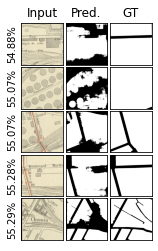

In [ ]:
# plot the n patches with the lowest IoU 
N = 5

fig1, ax1 = plt.subplots(N, 3)
plt.subplots_adjust(wspace=-0.82, hspace=0.05)

for i in range(N):
    ax1[i, 0].imshow(reshaped_patches[worst_iou_sorted_indices[i], :, :, :])
    ax1[i, 0].set_xticks([])
    ax1[i, 0].set_yticks([])
    ax1[i, 0].set(ylabel = f'{round(iou_scores[worst_iou_sorted_indices[i]]*100, 2)}%')
    ax1[i, 1].imshow(predictions[worst_iou_sorted_indices[i], :, :], cmap='Greys_r')
    ax1[i, 1].set_xticks([])
    ax1[i, 1].set_yticks([])
    ax1[i, 2].imshow(reshaped_ground_truth_patches[worst_iou_sorted_indices[i], :, :], cmap='Greys_r')
    ax1[i, 2].set_xticks([])
    ax1[i, 2].set_yticks([])

ax1[0, 0].set_title('Input')
ax1[0, 1].set_title('Pred.')
ax1[0, 2].set_title('GT')


plt.show()

fig1.savefig('worst_iou_scores.png', dpi=2500)

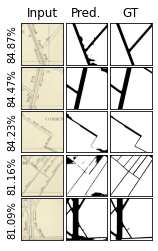

In [ ]:
# plot the n patches with the highest IoU 
N = 5

fig1, ax1 = plt.subplots(N, 3)
plt.subplots_adjust(wspace=-0.82, hspace=0.05)

for i in range(N):
    ax1[i, 0].imshow(reshaped_patches[best_iou_sorted_indices[i], :, :, :])
    ax1[i, 0].set_xticks([])
    ax1[i, 0].set_yticks([])
    ax1[i, 0].set(ylabel = f'{round(iou_scores[best_iou_sorted_indices[i]]*100, 2)}%')
    ax1[i, 1].imshow(predictions[best_iou_sorted_indices[i], :, :], cmap='Greys_r')
    ax1[i, 1].set_xticks([])
    ax1[i, 1].set_yticks([])
    ax1[i, 2].imshow(reshaped_ground_truth_patches[best_iou_sorted_indices[i], :, :], cmap='Greys_r')
    ax1[i, 2].set_xticks([])
    ax1[i, 2].set_yticks([])

ax1[0, 0].set_title('Input')
ax1[0, 1].set_title('Pred.')
ax1[0, 2].set_title('GT')

plt.show()

fig1.savefig('best_iou_scores.png', dpi=2500)

In [ ]:
input_image = x_initial_valid[0:6144, 0:8704]
ground_truth = y_initial_valid[0:6144, 0:8704].astype(int)
fig, axis = plt.subplots(1, 3)
axis[0].imshow(input_image)
axis[0].set_title('Input')
axis[0].set_xticks([])
axis[0].set_yticks([])
axis[1].imshow(ground_truth)
axis[1].set_title('Ground Truth Mask')
axis[1].set_xticks([])
axis[1].set_yticks([])
axis[2].imshow(d)
axis[2].set_title('Predicted Mask')
axis[2].set_xticks([])
axis[2].set_yticks([])
plt.show()

In [ ]:
fig.savefig('second_blood.png', dpi=2200)

1.0

In [ ]:
predictions


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 1],
        [1, 1, 1, ..., 0, 0, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 